In [1]:
import os
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

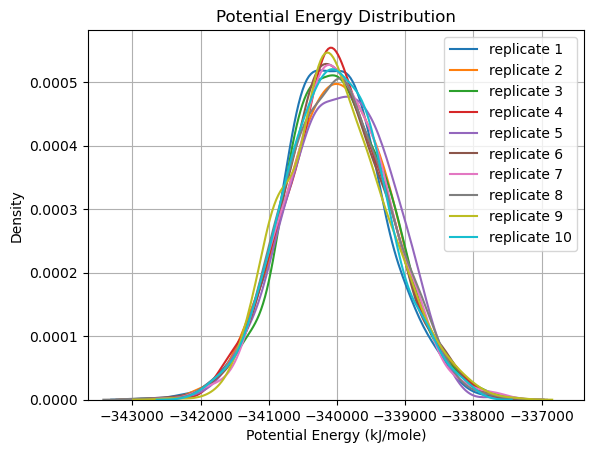

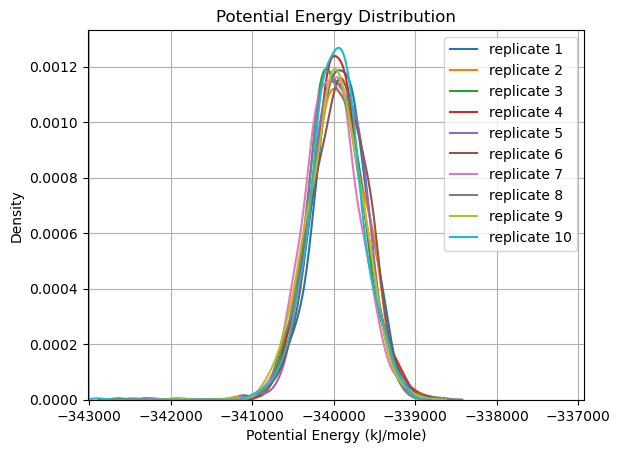

In [2]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return None

gmx_files = [f'gromacs/replicate_{i}/potential.xvg' for i in range(1, 11)]
#gmx_energy_arrays = plot_potential_energy('gromacs', gmx_files, 'line', window=10)
plot_potential_energy('gromacs', gmx_files, 'hist', window=1)
omm_files = [f'openmm/energy_data_{i}.csv' for i in range(1, 11)]
#omm_energy_arrays = plot_potential_energy('openmm', omm_files, 'line', window=50)
plot_potential_energy('openmm', omm_files, 'hist', window=5)

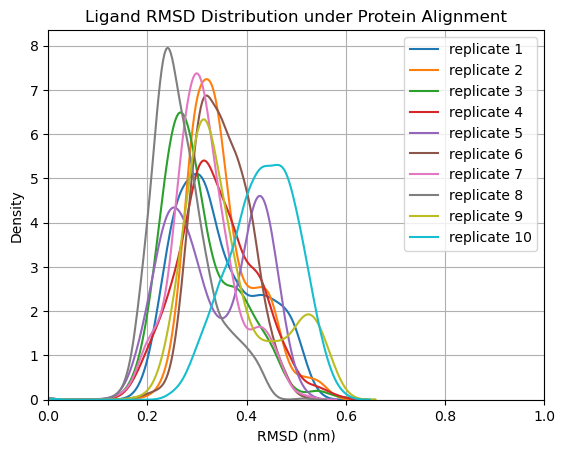

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and

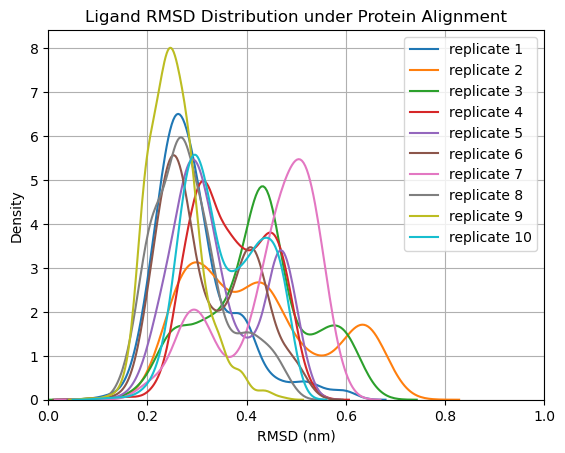

In [3]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        traj.image_molecules(inplace=True)
        frames = np.arange(0, traj.n_frames)
        protein_atoms = traj.topology.select('protein and name CA')
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.ylim(0.0, 1.0)
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.xlim(0.0, 1.0)
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return None

gmx_files = [f'gromacs/replicate_{i}/md.xtc' for i in range(1, 11)]
gmx_top_file = 'gromacs/min.gro'
plot_rmsd_fluctuations_multiple(gmx_files, gmx_top_file, 'hist', window=1)
omm_files = [f'/mnt/d/md_backup/binary_complex/openmm/NPT/trajectory_{i}.dcd' for i in range(1, 11)]
omm_top_file = 'openmm/complex_in_solvent.pdb'
plot_rmsd_fluctuations_multiple(omm_files, omm_top_file, 'hist', window=5)

In [ ]:
def plot_ligand_pca(traj_files, top_file, slice_step=1):

        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]

        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])

        traj_cont.image_molecules(inplace=True)

        protein_atoms = traj_cont.topology.select('protein and name CA')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=protein_atoms)

        ligand_atoms = traj_cont.topology.select('resname UNK')
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

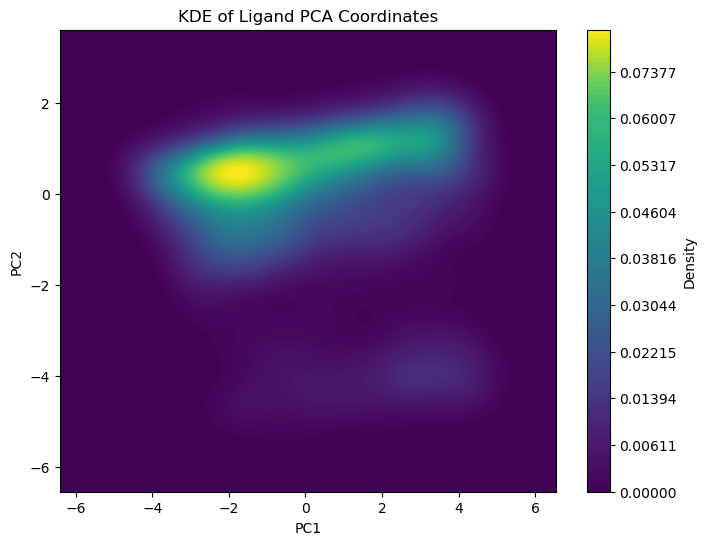

In [5]:
gmx_traj_cont = plot_ligand_pca(['gromacs/all_processed.xtc'], 'openmm/complex_in_solvent.pdb') # or gromacs/gromacs.gro as same topology

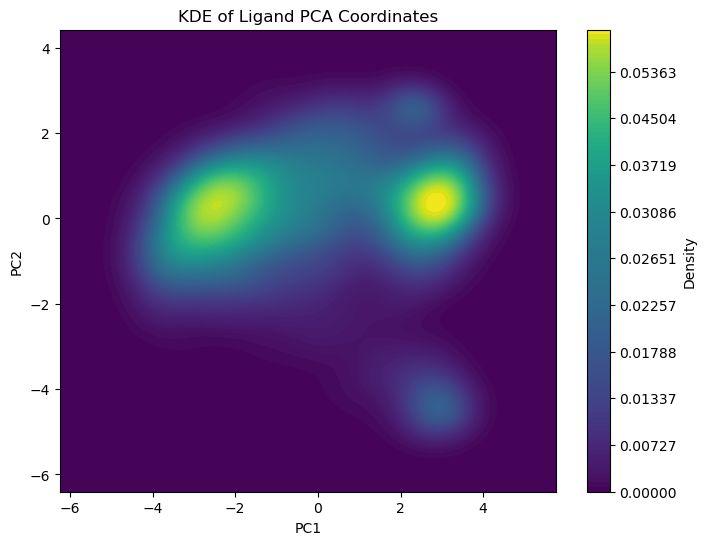

In [6]:
omm_traj_cont = plot_ligand_pca(['openmm/all_processed.xtc'], 'openmm/complex_in_solvent.pdb')

In [ ]:
#gmx_traj_cont.save('gromacs/all_processed.xtc')
#omm_traj_cont.save('openmm/all_processed.xtc')

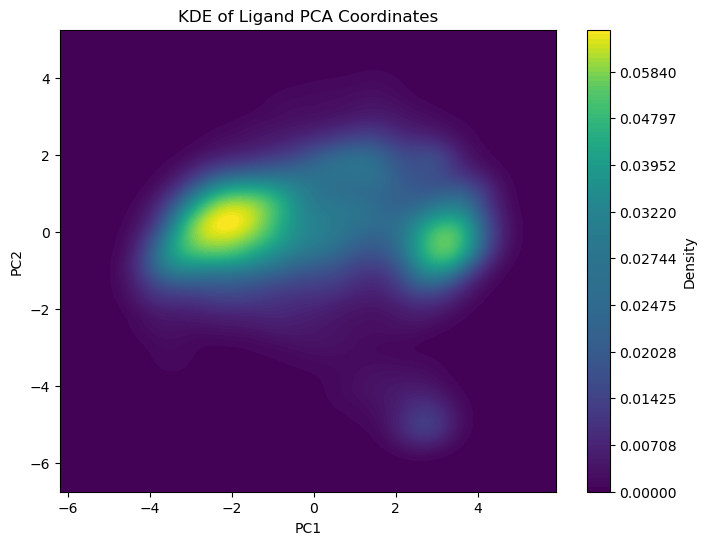

In [7]:
plot_ligand_pca(['clustering/merged.xtc'], 'clustering/complex_in_solvent.pdb')

In [2]:
def plot_ligand_fel(traj_files, top_file, grid_bins=20, T=300, unit='kJ/mol', slice_step=1):

    traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
    for i, traj_file in enumerate(traj_files[1:]):
        traj = md.load(traj_file, top=top_file)[::slice_step]
        traj_cont = md.join([traj_cont, traj])

    traj_cont.image_molecules(inplace=True)
    protein_atoms = traj_cont.topology.select('protein and name CA')
    traj_cont.superpose(traj_cont, frame=0, atom_indices=protein_atoms)

    n_frames = traj_cont.n_frames
    original_indices = np.arange(0, n_frames * slice_step, slice_step)

    ligand_atoms = traj_cont.topology.select('resname UNK')
    if not ligand_atoms.size:
        raise ValueError("Ligand 'UNK' not found. Check the residue name.")
        
    ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
    ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
    pca1 = PCA(n_components=2)
    reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
    
    PC1 = reduced_cartesian[:, 0]
    PC2 = reduced_cartesian[:, 1]

    data_map = np.column_stack((PC1, PC2, original_indices))
    
    hist, xedges, yedges = np.histogram2d(
        PC1, 
        PC2, 
        bins=grid_bins, 
        density=True
    )

    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    
    P = hist.T  # Transpose the probability matrix for correct plotting orientation

    # Define Boltzmann constants
    R = 8.314462618  # J/(mol*K)
    
    if unit == 'kJ/mol':
        R_unit = R / 1000.0 
    elif unit == 'kcal/mol':
        R_unit = R / 4184.0 
    else:
        raise ValueError("Unit must be 'kJ/mol' or 'kcal/mol'.")
        
    P_min_nonzero = P[P > 0].min()
    P_corrected = np.where(P > 0, P, P_min_nonzero)
    
    G = -R_unit * T * np.log(P_corrected)
    G_min = G.min()
    G_shifted = G - G_min

    plt.figure(figsize=(9, 7))

    plt.contour(
        xcenters, 
        ycenters, 
        G_shifted, 
        levels=np.arange(0, G_shifted.max(), 5), # E.g., lines every 5 units
        colors='black', 
        linewidths=0.5, 
        alpha=0.5
    )
    
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title(f'Free Energy Landscape (FEL) of Ligand PCA')
    
    # Add color bar
    contour = plt.contourf(
        xcenters, 
        ycenters, 
        G_shifted, 
        levels=20, # Number of energy levels to plot
        cmap="turbo"
    )
    plt.colorbar(contour, label=f'Free Energy ({unit})')

    plt.legend()
    plt.show()
    plt.close()
    
    return data_map, hist, xedges, yedges

/tmp/ipykernel_1777/2438526921.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


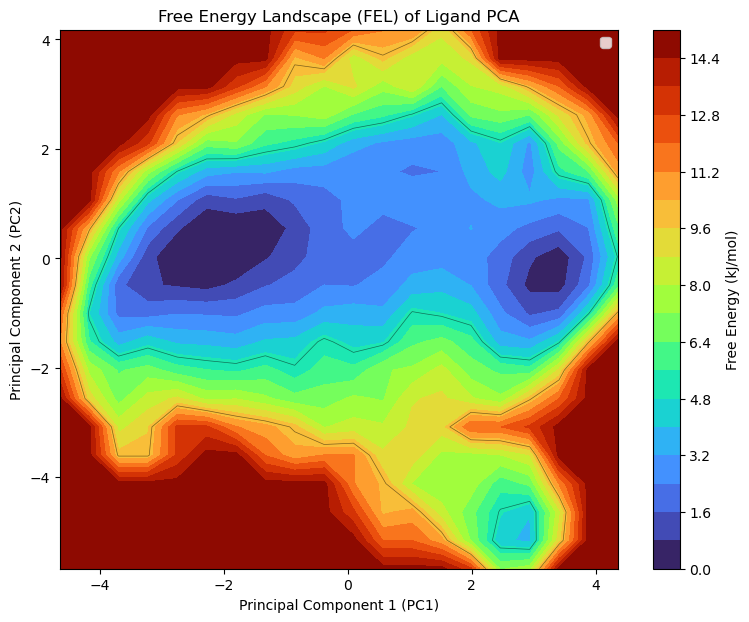

In [3]:
data_map, hist, xedges, yedges = plot_ligand_fel(['clustering/merged.xtc'], 'clustering/complex_in_solvent.pdb', grid_bins=20, T=300, unit='kJ/mol', slice_step=1)

In [ ]:
def get_top_k_density_bins(hist, xedges, yedges, data_map, k=5):
    hist_flat = hist.flatten()
    top_k_flat_indices = np.argsort(hist_flat)[-k:][::-1]
    top_k_2d_indices = np.unravel_index(top_k_flat_indices, hist.shape)
    top_k_values = hist[top_k_2d_indices]
    
    results = []
    
    for rank in range(k):
        i = top_k_2d_indices[1][rank]
        j = top_k_2d_indices[0][rank]
        density = top_k_values[rank]

        pc1_min = xedges[j]
        pc1_max = xedges[j+1]
        pc2_min = yedges[i]
        pc2_max = yedges[i+1]
        
        results.append({
            'Rank': rank + 1,
            'Density': density,
            'PC1_Range': f'[{pc1_min:.4f}, {pc1_max:.4f}]',
            'PC2_Range': f'[{pc2_min:.4f}, {pc2_max:.4f}]',
            'PC1_Bin_Index': j,
            'PC2_Bin_Index': i
        })

    return pd.DataFrame(results)

hist_df = get_top_k_density_bins(hist, xedges, yedges, k=400)#20*20
hist_df.iloc[0:10,]
#rank 1 and rank 6

,Rank,Density,PC1_Range,PC2_Range,PC1_Bin_Index,PC2_Bin_Index
0,1,0.074079,"[-2.0419, -1.5681]","[0.2906, 0.8089]",6,12
1,2,0.073672,"[-2.5157, -2.0419]","[-0.2277, 0.2906]",5,11
2,3,0.073061,"[-2.0419, -1.5681]","[-0.2277, 0.2906]",6,11
3,4,0.073061,"[-2.5157, -2.0419]","[0.2906, 0.8089]",5,12
4,5,0.072451,"[-2.9895, -2.5157]","[-0.2277, 0.2906]",4,11
5,6,0.066549,"[3.1698, 3.6436]","[-0.2277, 0.2906]",17,11
6,7,0.063699,"[-1.5681, -1.0943]","[0.2906, 0.8089]",7,12
7,8,0.062682,"[3.1698, 3.6436]","[-0.7460, -0.2277]",17,10
8,9,0.060443,"[-2.5157, -2.0419]","[-0.7460, -0.2277]",5,10
9,10,0.059426,"[2.6960, 3.1698]","[-0.7460, -0.2277]",16,10


In [ ]:
hist_df.loc[hist_df['PC2_Range'].str.split(', ').str[1].str[:-1].astype(float) < -3.0]
#rank 100

,Rank,Density,PC1_Range,PC2_Range,PC1_Bin_Index,PC2_Bin_Index
99,100,0.016281,"[2.6960, 3.1698]","[-5.4106, -4.8923]",16,1
103,104,0.014653,"[2.6960, 3.1698]","[-4.8923, -4.3740]",16,2
105,106,0.013635,"[2.2222, 2.6960]","[-5.4106, -4.8923]",15,1
119,120,0.010379,"[2.2222, 2.6960]","[-4.8923, -4.3740]",15,2
135,136,0.006919,"[2.2222, 2.6960]","[-4.3740, -3.8557]",15,3
...,...,...,...,...,...,...
390,391,0.000000,"[4.1174, 4.5912]","[-5.4106, -4.8923]",19,1
392,393,0.000000,"[-4.4109, -3.9371]","[-4.3740, -3.8557]",1,3
393,394,0.000000,"[-4.4109, -3.9371]","[-4.8923, -4.3740]",1,2
394,395,0.000000,"[-4.4109, -3.9371]","[-5.4106, -4.8923]",1,1


In [52]:
# convert the numpy array to a pandas DataFrame and show a preview
data_map_df = pd.DataFrame(data_map, columns=['PC1', 'PC2', 'Original_Frame_Index'])
data_map_df['Original_Frame_Index'] = data_map_df['Original_Frame_Index'].astype(int)
data_map_df.tail()

,PC1,PC2,Original_Frame_Index
20005,2.474942,0.984053,20005
20006,1.924758,0.475998,20006
20007,2.106341,1.325428,20007
20008,2.452677,0.751122,20008
20009,2.917567,0.987972,20009


In [ ]:
# select frames in the specified PC1/PC2 range and return the original frame indices
cluster1_frames = data_map_df.loc[
    (data_map_df['PC1'] > -2.0419) &
    (data_map_df['PC1'] < -1.5681) &
    (data_map_df['PC2'] > 0.2906) &
    (data_map_df['PC2'] < 0.8089),
    'Original_Frame_Index'
].tolist()
cluster6_frames = data_map_df.loc[
    (data_map_df['PC1'] > 3.1698) &
    (data_map_df['PC1'] < 3.6436) &
    (data_map_df['PC2'] > -0.2277) &
    (data_map_df['PC2'] < 0.2906),
    'Original_Frame_Index'
].tolist()
cluster100_frames = data_map_df.loc[
    (data_map_df['PC1'] > 2.6960) &
    (data_map_df['PC1'] < 3.1698) &
    (data_map_df['PC2'] > -5.4106) &
    (data_map_df['PC2'] < -4.8923),
    'Original_Frame_Index'
].tolist()
len(cluster1_frames), len(cluster6_frames), len(cluster100_frames)

(364, 327, 80)

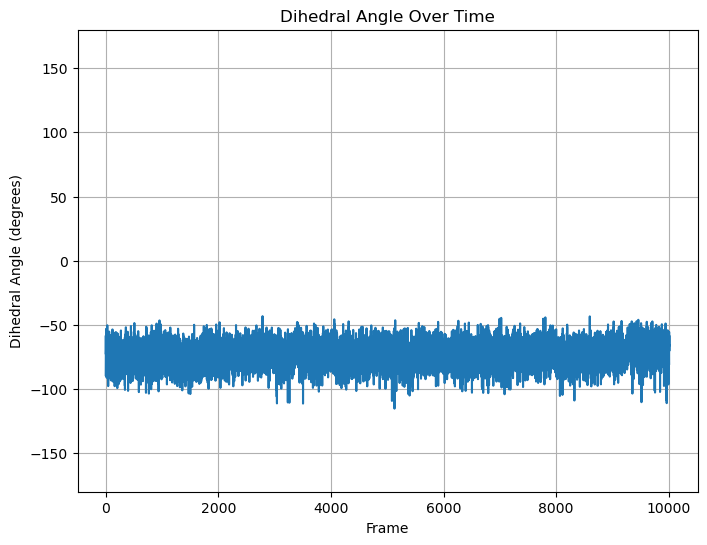

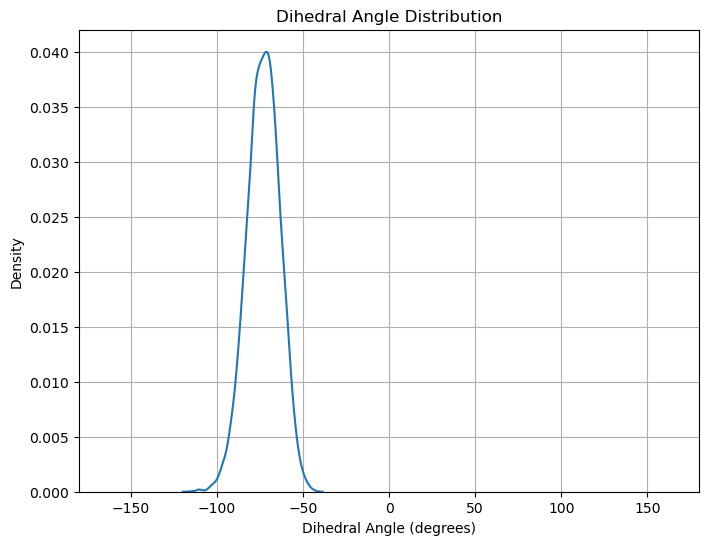

-73.140434


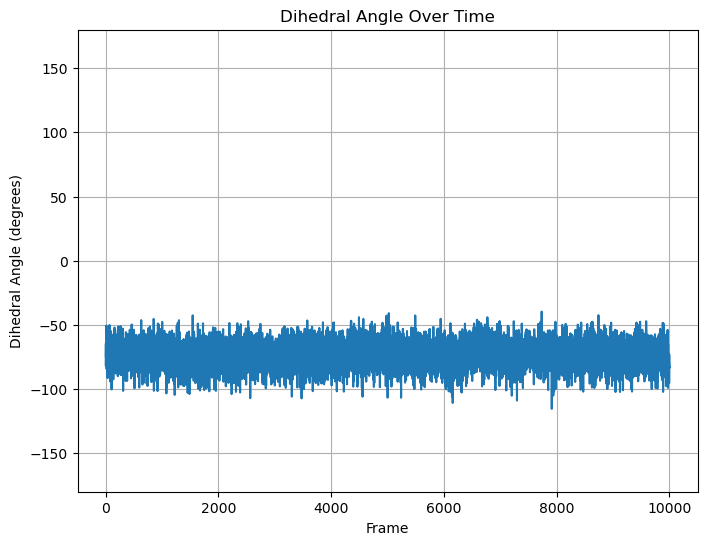

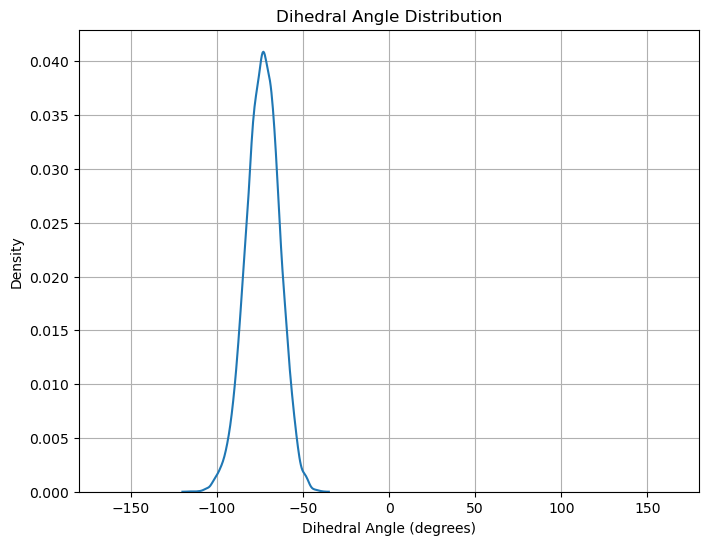

-73.46633


In [8]:
atom_indices = [2510, 2509, 2508, 2503]

def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(dihedral_angles_deg)), dihedral_angles_deg)
    plt.xlabel('Frame')
    plt.ylabel('Dihedral Angle (degrees)')
    plt.title('Dihedral Angle Over Time')
    plt.ylim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

print(plot_dihedral_angles(gmx_traj_cont, atom_indices))
print(plot_dihedral_angles(omm_traj_cont, atom_indices))
